In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import copy as cp
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, cross_val_predict 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix, accuracy_score

from typing import Tuple

In [2]:
data = pd.read_csv('../../Data/grade_feat_scaled.csv')
data.head(5)

,grade,loan_status_bin
0,0.196276,0.0
1,0.196276,0.0
2,-0.575883,0.0
3,2.512753,0.0
4,0.196276,0.0


In [3]:
data.loan_status_bin.value_counts()
#0 = Loan Fully Paid
#1 = Loan Defaulted

0.0    1076751
1.0     268559
Name: loan_status_bin, dtype: int64

In [4]:
X = data.drop('loan_status_bin', axis=1)
X.shape

(1345310, 1)

In [5]:
y = data['loan_status_bin']

In [6]:
lr1 = LogisticRegression()

In [7]:
steps = [('model', lr1)]
pipeline = Pipeline(steps=steps)

In [8]:
#Accuracy:

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1) 
print(scores)

score = np.mean(scores)
print(score)

[0.7981692  0.79787187 0.79770462 0.79836246 0.79828441]
0.7980785097858487


In [9]:
#Aggregated Confusion Matrix From RepeatedStratifiedKFold: 
y_pred = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1)
conf_mat = confusion_matrix(y, y_pred)
conf_mat

array([[1054612,   22139],
       [ 249508,   19051]])

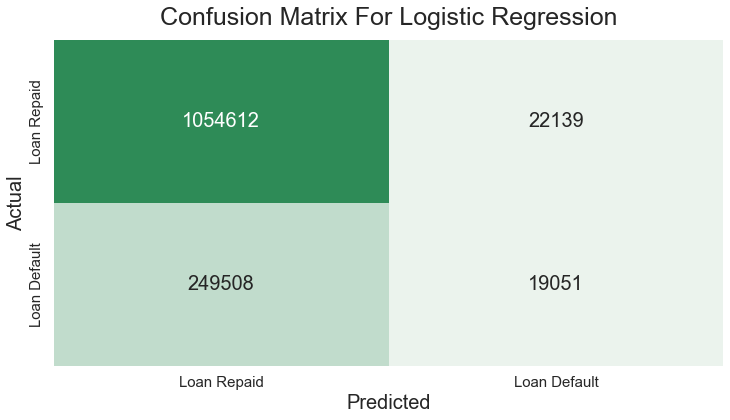

In [10]:
sns.set(rc = {'figure.figsize':(12,6)})
#cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sns.light_palette('seagreen', as_cmap=True)

res = sns.heatmap(conf_mat, annot=True, fmt='d', annot_kws={"size":20},
#            xticklabels = ['Good = Paid In Full', 'Bad = Default'],
#            yticklabels = ['Loan Paid In Full', 'Bad = Default'], 
            cmap=cmap, cbar=False)

res.set_xticklabels(['Loan Repaid', 'Loan Default'], fontsize=15)
res.set_yticklabels(['Loan Repaid', 'Loan Default'], fontsize=15)


plt.title('Confusion Matrix For Logistic Regression', fontsize=25, pad=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);

In [11]:
accuracy_score(y, y_pred)

0.7980785097858486

In [12]:
TN, FP, FN, TP = conf_mat.ravel()
print(TP)
print(FP)
print(FN)
print(TN)
print((TP + TN) / (TN + TP + FP + FN))

19051
22139
249508
1054612
0.7980785097858486


In [13]:
#Re-examine original pool of accepted LC Loans: 

print(data.loan_status_bin.value_counts())
#0 = Loan Fully Paid
#1 = Loan Defaulted

good_loan = data.loan_status_bin.value_counts()[0]
bad_loan = data.loan_status_bin.value_counts()[1]

print()
print(good_loan / (good_loan + bad_loan))

#Random investment into accepted loans would give us 80% chance of pickkng a good loan

0.0    1076751
1.0     268559
Name: loan_status_bin, dtype: int64

0.8003738915194267


In [14]:
#Negative Predictive Value
#Logistic model does not do better than Null Model (or Randomly choosing an investment)
TN / (TN + FN)

0.8086771156028586

In [15]:
#Basic Metrics I ~ True Positive Rate
#1. True Positive Rate (=Recall or Sensitivity) = TP / (TP + FN)
TPR = TP / (TP+FN)
TPR

0.07093785723062716

In [16]:
#Cross Checking Recall from Model:

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='recall', cv=cv, n_jobs=-1) 

print(scores)
score = np.mean(scores)
print(score)

[0.07099104 0.07102696 0.07030086 0.07167858 0.07069184]
0.07093785742867391


In [17]:
#Basic Metrics II ~ False Positive Rate
#2. False Postive Rate = FP / (FP + TN)
FPR = FP / (FP + TN)
FPR

0.02056092819974163

In [18]:
#Part II - Experimenting with Different Thresholds ~ Optimal TPR - FPR: 

In [19]:
class LogisticRegressionWithThreshold(LogisticRegression):
    def predict(self, X, threshold=None):
        if threshold == None: # If no threshold passed in, simply call the base class predict, effectively threshold=0.5
            return LogisticRegression.predict(self, X)
        else:
            y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
            y_pred_with_threshold = (y_scores >= threshold).astype(int)

            return y_pred_with_threshold
    
    def threshold_from_optimal_tpr_minus_fpr(self, X, y):
        y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
        fpr, tpr, thresholds = roc_curve(y, y_scores) 

        optimal_idx = np.argmax(tpr - fpr)

        return thresholds[optimal_idx], tpr[optimal_idx] - fpr[optimal_idx]

In [20]:
X_array = X.iloc[:,0:].values
X_array

array([[ 0.19627602],
       [ 0.19627602],
       [-0.57588288],
       ...,
       [ 0.19627602],
       [ 0.19627602],
       [ 0.19627602]])

In [21]:
X_array = X.to_numpy()
X_array

array([[ 0.19627602],
       [ 0.19627602],
       [-0.57588288],
       ...,
       [ 0.19627602],
       [ 0.19627602],
       [ 0.19627602]])

In [22]:
len(X_array)

1345310

In [23]:
y_array = y.to_numpy()
y_array

array([0., 0., 0., ..., 1., 0., 1.])

In [24]:
#Obtaining optimal mean threshold value via StratifiedKFold: 

lrt = LogisticRegressionWithThreshold()
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

thresholds = []

for train_index, test_index in rskf.split(X,y):
    lrt.fit(X_array[train_index], y_array[train_index])
    threshold, optimal_tpr_minus_fpr = lrt.threshold_from_optimal_tpr_minus_fpr(X_array[train_index], y_array[train_index])
    thresholds.append(round(threshold,5))
    
print (thresholds)
optimal = np.mean(thresholds)
print(optimal)

[0.20135, 0.2015, 0.20138, 0.20139, 0.20134]
0.20139200000000002


In [25]:
steps = [('model', lr1)]
pipeline = Pipeline(steps=steps)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

In [26]:
y_pred2 = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1, method='predict_proba')

In [27]:
len(y_pred2)

1345310

In [28]:
y_pred2

array([[0.79850161, 0.20149839],
       [0.79860692, 0.20139308],
       [0.86595566, 0.13404434],
       ...,
       [0.79862405, 0.20137595],
       [0.79864786, 0.20135214],
       [0.79860692, 0.20139308]])

In [29]:
#Obtaining classification based on desired threshold: 

threshold = optimal
y_pred2 = (y_pred2[:, 1] > threshold).astype('float')
#confusion_matrix(y_test, y_pred)

In [30]:
y_pred2

array([1., 1., 0., ..., 0., 0., 1.])

In [31]:
len(y_pred2)

1345310

In [32]:
conf_mat2 = confusion_matrix(y, y_pred2)
conf_mat2

array([[738907, 337844],
       [118216, 150343]])

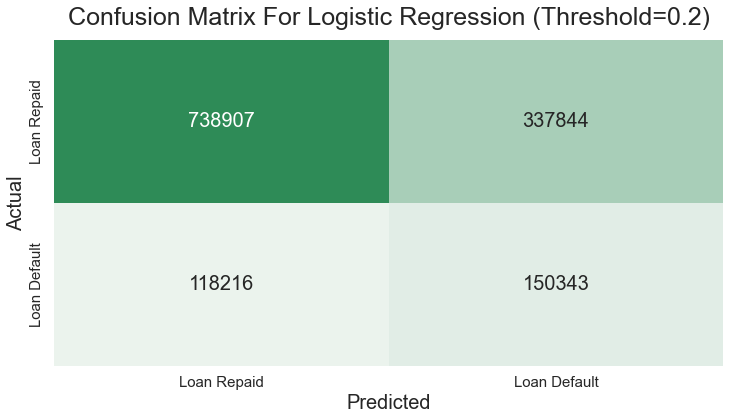

In [33]:
sns.set(rc = {'figure.figsize':(12,6)})
#cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sns.light_palette('seagreen', as_cmap=True)

res = sns.heatmap(conf_mat2, annot=True, fmt='d', annot_kws={"size":20},
#            xticklabels = ['Good = Paid In Full', 'Bad = Default'],
#            yticklabels = ['Loan Paid In Full', 'Bad = Default'], 
            cmap=cmap, cbar=False)

res.set_xticklabels(['Loan Repaid', 'Loan Default'], fontsize=15)
res.set_yticklabels(['Loan Repaid', 'Loan Default'], fontsize=15)


plt.title('Confusion Matrix For Logistic Regression (Threshold=0.2)', fontsize=25, pad=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);

In [34]:
accuracy_score(y, y_pred2)

0.661000066899079

In [35]:
TN, FP, FN, TP = conf_mat2.ravel()
print(TP)
print(FP)
print(FN)
print(TN)
print((TP + TN) / (TN + TP + FP + FN))

150343
337844
118216
738907
0.661000066899079


In [37]:
#Re-examine original pool of accepted LC Loans: 

print(data.loan_status_bin.value_counts())
#0 = Loan Fully Paid
#1 = Loan Defaulted

good_loan = data.loan_status_bin.value_counts()[0]
bad_loan = data.loan_status_bin.value_counts()[1]

print()
print(good_loan / (good_loan + bad_loan))

#Random investment into accepted loans would give us 80% chance of pickkng a good loan

0.0    1076751
1.0     268559
Name: loan_status_bin, dtype: int64

0.8003738915194267


In [36]:
#Negative Predictive Value
#Logistic with adjusted threshold of 0.2 does BETTER than Null Model (or Randomly choosing an investment)
TN / (TN + FN)

0.8620781381435336

In [38]:
#Basic Metrics I ~ True Positive Rate
#1. True Positive Rate (=Recall or Sensitivity) = TP / (TP + FN)
TPR = TP / (TP+FN)
TPR

0.5598136722284489

In [41]:
#Basic Metrics II ~ False Positive Rate
#2. False Postive Rate = FP / (FP + TN)
FPR = FP / (FP + TN)
FPR

0.313762420466756

In [45]:
X_array = X.iloc[:,0:].values
X_array

array([[ 0.19627602],
       [ 0.19627602],
       [-0.57588288],
       ...,
       [ 0.19627602],
       [ 0.19627602],
       [ 0.19627602]])

In [46]:
y_array = y.to_numpy()
y_array

array([0., 0., 0., ..., 1., 0., 1.])

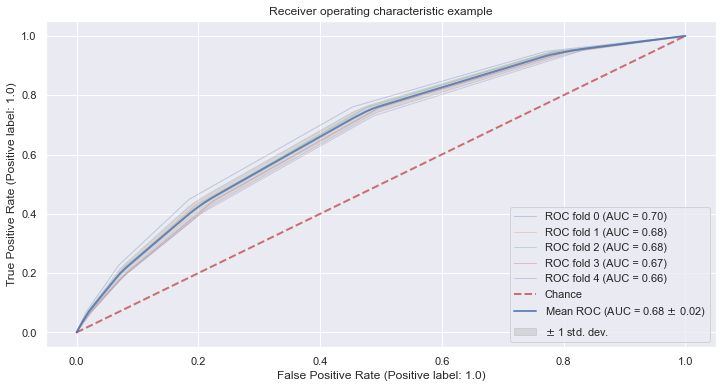

In [47]:
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5)
#cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
classifier = LogisticRegression()

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X_array, y_array)):
    classifier.fit(X_array[train], y_array[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X_array[test],
        y_array[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic example",
)
ax.legend(loc="lower right")
plt.show()

In [ ]:
#diff between stratified kfold and repeated stratified kfold? 